In [2]:
from Dataset import *
from Utils import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import regularizers
import keras.backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')
% matplotlib inline

Using TensorFlow backend.


In [3]:
embedding_index, vtr_dim = import_glove(25)

In [4]:
col_fire_12 = dataset('2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv')
col_flood_13 = dataset('2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv')
aus_fire_13 = dataset('2013_Australia_bushfire/2013_Australia_bushfire-tweets_labeled.csv')
aus_flood_13 = dataset('2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv')
col_fire_12_g = col_fire_12.glove(embedding_index, vtr_dim)
col_flood_13_g = col_flood_13.glove(embedding_index, vtr_dim)
aus_fire_13_g = aus_fire_13.glove(embedding_index, vtr_dim)
aus_flood_13_g = aus_flood_13.glove(embedding_index, vtr_dim)
col_fire_12_lb = to_categorical(col_fire_12.df.label)
col_flood_13_lb = to_categorical(col_flood_13.df.label)
aus_fire_13_lb = to_categorical(aus_fire_13.df.label)
aus_flood_13_lb = to_categorical(aus_flood_13.df.label)

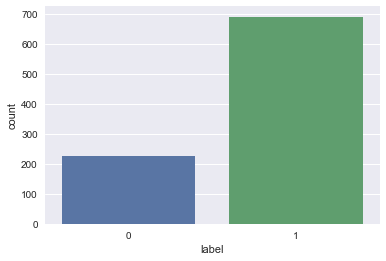

In [54]:
sns.countplot(x='label', data=col_flood_13.df)

In [5]:
def create_lstm_model(bidir=True, n_lstm=32, dropout=0.3, re_dropout=0.3, penalty=0.01, input_shape=25, initial_lr=0.001, dense=False, n_dense=None):
    model = Sequential()
    if bidir:
        model.add(Bidirectional(LSTM(n_lstm, kernel_initializer='he_normal', recurrent_dropout=re_dropout, dropout=dropout, 
                                     kernel_regularizer=regularizers.l2(penalty)),input_shape=(None,input_shape)))
    else:
        model.add(LSTM(n_lstm, kernel_initializer='he_normal', recurrent_dropout=re_dropout, dropout=dropout, 
                                     kernel_regularizer=regularizers.l2(penalty),input_shape=(None,input_shape)))
    if dense:
        if n_dense is None:
            n_dense = 64
        model.add(Dense(n_dense, activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(penalty)))
        model.add(Dropout(0.3))
    optimizer = Adam(lr=initial_lr)
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [6]:
def incremental_learning_prob(model, tweets, step=20, threshold=0.75):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= threshold or y_pred[j][1] >= threshold])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= threshold or y_pred[j][1] >= threshold]
        label = to_categorical(map(lambda x: 0 if x[0]>=threshold else 1, y_confident))
        weight = np.array([(max(i)-0.5)/0.5 for i in y_confident])
        model.train_on_batch(x_confident, label, sample_weight=weight)#, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [7]:
def incremental_learning_det(model, tweets, step=10, confidence=0.95):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence]
        label = to_categorical(map(lambda x: 0 if x[0]>=confidence else 1, y_confident))
        model.train_on_batch(x_confident, label)#, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [8]:
def shuffle_train(model, data, text, path, k=10, n_epoch=10, val_size=0.2, batch_size=64, earlystop=None):
    min_val_loss = float('inf')
    if isinstance(earlystop, int):
        n_earlystopping = [earlystop]*k
    elif isinstance(earlystop, list) and len(earlystop)==k:
        n_earlystopping = earlystop
    else:
        print 'earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting'
        n_earlystopping = [7]*(k/4)+[6]*(k/4)+[5]*(k/4)+[4]*(k-k/4*3)
    mcp = ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0.0001)
    history = {'acc':[], 'loss':[], 'val_acc':[], 'val_loss':[]}
    ##### n_epoch*k epochs in total######
    CLR = K.get_value(model.optimizer.lr)
    for i in range(k):
        K.set_value(model.optimizer.lr, CLR)
        df = data.df.sample(frac=1)
        tweet_g = text[df.index.values]
        his = model.fit(tweet_g, to_categorical(df.label), callbacks=[EarlyStopping(monitor='val_loss', patience=n_earlystopping[i], min_delta=0.001),
            mcp, rlr], validation_split=val_size, batch_size=batch_size, epochs=n_epoch)
        for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
            history[metric].extend(his.history[metric])
        if min(his.history['val_loss']) < min_val_loss:
            min_val_loss = min(his.history['val_loss'])
        if len(his.history['acc']) < n_epoch:
            break
        CLR = K.get_value(model.optimizer.lr)
        model.load_weights(path)
    model.save(path)
    return history

In [9]:
def metric_drawing(title, path=None, Model=None):
    if Model is None:
        model = load_model(path)
    y_p1 = model.predict(col_flood_13_g)
    y_pred1 = []
    y_p2 = model.predict(aus_fire_13_g)
    y_pred2 = []
    y_p3 = model.predict(aus_flood_13_g)
    y_pred3 = []
    precision = []
    recall = []
    f1 = []
    for y in y_p1:
        if y[0]>y[1]:
            y_pred1.append(0)
        else:
            y_pred1.append(1)
    precision.append(metrics.precision_score(col_flood_13.df.label, y_pred1))
    recall.append(metrics.recall_score(col_flood_13.df.label, y_pred1))
    f1.append(metrics.f1_score(col_flood_13.df.label, y_pred1))
    for y in y_p2:
        if y[0]>y[1]:
            y_pred2.append(0)
        else:
            y_pred2.append(1)
    precision.append(metrics.precision_score(aus_fire_13.df.label, y_pred2))
    recall.append(metrics.recall_score(aus_fire_13.df.label, y_pred2))
    f1.append(metrics.f1_score(aus_fire_13.df.label, y_pred2))
    for y in y_p3:
        if y[0]>y[1]:
            y_pred3.append(0)
        else:
            y_pred3.append(1)
    precision.append(metrics.precision_score(aus_flood_13.df.label, y_pred3))
    recall.append(metrics.recall_score(aus_flood_13.df.label, y_pred3))
    f1.append(metrics.f1_score(aus_flood_13.df.label, y_pred3))

    plt.bar([0.9,1.9,2.9], precision, width=0.1, label='precision')
    plt.bar([1,2,3], recall, width=0.1, label='recall')
    plt.bar([1.1,2.1,3.1], f1, width=0.1, label='f1-score')
    plt.xticks([1,2,3], ['col_flood_13', 'aus_fire_13', 'aus_flood_13'])
    plt.ylim([0,1])
    plt.legend(loc='best')
    plt.xlabel('disaster')
    plt.ylabel('score')
    plt.title(title)
    plt.show()
    return precision, recall, f1

In [10]:
def plot_history(history, title, dictionary=False):
    plt.figure(figsize=(16,6))
    plt.suptitle(title)
    if dictionary:
        plt.subplot(121)
        n_epoch = len(history['acc'])
        plt.plot(range(1, n_epoch+1), history['loss'], label='loss')
        plt.plot(range(1, n_epoch+1), history['val_loss'], label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(range(1, n_epoch+1), history['acc'], label='acc')
        plt.plot(range(1, n_epoch+1), history['val_acc'], label='val_acc')
    else:
        plt.subplot(121)
        n_epoch = len(history.history['acc'])
        plt.plot(range(1, n_epoch+1), history.history['loss'], label='loss')
        plt.plot(range(1, n_epoch+1), history.history['val_loss'], label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(range(1, n_epoch+1), history.history['acc'], label='acc')
        plt.plot(range(1, n_epoch+1), history.history['val_acc'], label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

In [11]:
def increment_learning_result(path, step=10, confidence=0.9, threshold=0.75, separate=True):
    
    print 'no incremental learning:'
    lstm_model = load_model(path)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
    
    ######################try hard label incremental learning####################################
    print 'hard label:'
    lstm_model = load_model(path)
    incremental_learning_det(lstm_model, col_flood_13_g, step=step, confidence=confidence)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

    if separate:
        lstm_model = load_model(path)
    incremental_learning_det(lstm_model, aus_fire_13_g, step=step, confidence=confidence)
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
    
    if separate:
        lstm_model = load_model(path)
    incremental_learning_det(lstm_model, aus_flood_13_g, step=step, confidence=confidence)
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

    ######################try weighted label incremental learning####################################
    print 'labels with weight:'
    lstm_model = load_model(path)
    incremental_learning_prob(lstm_model, col_flood_13_g, step=step, threshold=threshold)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
    
    if separate:
        lstm_model = load_model(path)
    incremental_learning_prob(lstm_model, aus_fire_13_g, step=step, threshold=threshold)
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

    if separate:
        lstm_model = load_model(path)
    incremental_learning_prob(lstm_model, aus_flood_13_g, step=step, threshold=threshold)
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

In LSTM_explore (the quite messy one), we found that output dimension of LSTM layer does not affect accuracy much but has an impact on training speed. Based on the results we got, we decided to use 64 as the output dimension of LSTM layer. Default dropout and recurrent dropout are 0.3. Default regularizer is 0.01 L-2.

|dim |time |val_loss |val_acc |acc|
| --- | --- | --- | --- | --- |
|4 |7min10s |0.4042 |0.8423 |0.7951|
|8 |6min59s |0.3789 |0.8571 |0.8092|
|16 |5min52s |0.3895 |0.8393 |0.8143|
|32 |5min17s |0.3846 |0.8274 |0.8335|
|64 |4min50s |0.3914 |0.8720 |0.8528|
|128 |6min18s |0.4529 |0.8304 |0.8937|

## Default

In [73]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0.01, dropout=0.3, re_dropout=0.3)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_64.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0.0001)
history=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp, rlr], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 32s 41ms/step - loss: 4.5235 - acc: 0.5570 - val_loss: 4.2864 - val_acc: 0.6607
Epoch 2/100
781/781 [==============================] - 5s 6ms/step - loss: 4.1641 - acc: 0.6428 - val_loss: 3.9417 - val_acc: 0.6964
Epoch 3/100
781/781 [==============================] - 5s 6ms/step - loss: 3.8411 - acc: 0.6799 - val_loss: 3.6289 - val_acc: 0.7024
Epoch 4/100
781/781 [==============================] - 5s 6ms/step - loss: 3.5404 - acc: 0.7029 - val_loss: 3.3431 - val_acc: 0.7321
Epoch 5/100
781/781 [==============================] - 5s 6ms/step - loss: 3.2805 - acc: 0.7106 - val_loss: 3.0889 - val_acc: 0.7530
Epoch 6/100
781/781 [==============================] - 5s 6ms/step - loss: 3.0167 - acc: 0.7439 - val_loss: 2.8511 - val_acc: 0.7768
Epoch 7/100
781/781 [==============================] - 5s 6ms/step - loss: 2.7981 - acc: 0.7593 - val_loss: 2.6556 - val_acc: 0.7619
Epoch 8/100
781/781 [

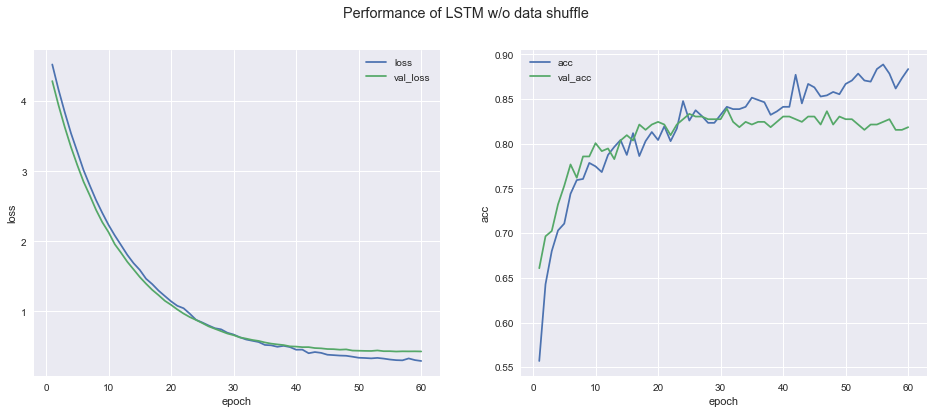

In [75]:
plot_history(history,'Performance of LSTM w/o data shuffle')

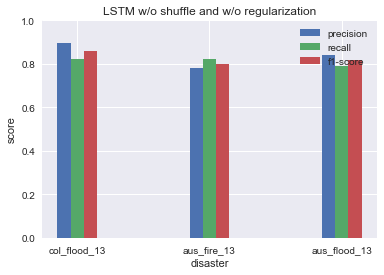

In [41]:
p, r, f = metric_drawing('LSTM', path='bi_lstm_64.h5')

In [42]:
print p, r, f

[0.89465408805031443, 0.78164556962025311, 0.84160000000000001] [0.8234442836468886, 0.82059800664451832, 0.79097744360902256] [0.85757347400150707, 0.80064829821717975, 0.81550387596899232]


In [44]:
increment_learning_result(path='bi_lstm_64.h5')

no incremental learning:
917/917 [==============================] - 4s 4ms/step
[0.52799193127204702, 0.79389313009599038]
1079/1079 [==============================] - 2s 2ms/step
[0.53492536541485369, 0.77201112146395245]
1112/1112 [==============================] - 2s 2ms/step
[0.53415109528054439, 0.78597122302158273]
hard label:
917/917 [==============================] - 4s 5ms/step
[0.51716297513916032, 0.82006543107745167]
1079/1079 [==============================] - 5s 5ms/step
[0.59344746079900068, 0.77664504176052329]
1112/1112 [==============================] - 5s 4ms/step
[0.53622095662055258, 0.80845323783888234]
labels with weight:
917/917 [==============================] - 4s 5ms/step
[0.51797663840498764, 0.82006543107745167]
1079/1079 [==============================] - 5s 5ms/step
[0.58265483882053792, 0.76830398522669574]
1112/1112 [==============================] - 5s 4ms/step
[0.55051320319553076, 0.80845323741007191]


## w/o regularizer

In [45]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0, dropout=0.3, re_dropout=0.3)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_no_re.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 12s 16ms/step - loss: 0.6967 - acc: 0.5365 - val_loss: 0.6682 - val_acc: 0.6190
Epoch 2/100
781/781 [==============================] - 5s 7ms/step - loss: 0.6662 - acc: 0.6120 - val_loss: 0.6303 - val_acc: 0.6339
Epoch 3/100
781/781 [==============================] - 5s 6ms/step - loss: 0.6324 - acc: 0.6466 - val_loss: 0.5979 - val_acc: 0.6875
Epoch 4/100
781/781 [==============================] - 4s 6ms/step - loss: 0.6085 - acc: 0.6863 - val_loss: 0.5663 - val_acc: 0.7024
Epoch 5/100
781/781 [==============================] - 4s 6ms/step - loss: 0.5924 - acc: 0.6914 - val_loss: 0.5363 - val_acc: 0.7173
Epoch 6/100
781/781 [==============================] - 4s 6ms/step - loss: 0.5696 - acc: 0.7247 - val_loss: 0.5258 - val_acc: 0.7143
Epoch 7/100
781/781 [==============================] - 4s 6ms/step - loss: 0.5566 - acc: 0.7311 - val_loss: 0.4949 - val_acc: 0.7500
Epoch 8/100
781/781 [

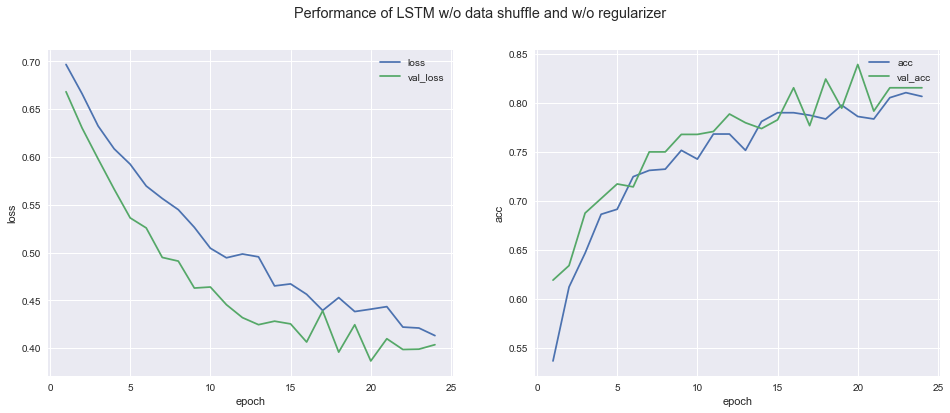

In [46]:
plot_history(history,'Performance of LSTM w/o data shuffle and w/o regularizer')

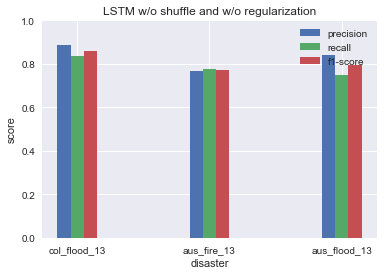

In [47]:
p, r, f = metric_drawing('LSTM w/o shuffle and w/o regularization', path='bi_lstm_no_re.h5')

In [48]:
print p, r, f

[0.88632872503840243, 0.76721311475409837, 0.84148397976391232] [0.83502170767004347, 0.77740863787375414, 0.75037593984962403] [0.85991058122205655, 0.7722772277227723, 0.7933227344992051]


In [49]:
increment_learning_result(path='bi_lstm_no_re.h5')

no incremental learning:
917/917 [==============================] - 4s 5ms/step
[0.4725726729780923, 0.79498364257188503]
1079/1079 [==============================] - 2s 2ms/step
[0.50785084481698917, 0.74420759968452699]
1112/1112 [==============================] - 2s 2ms/step
[0.5035082294786577, 0.76618704993090181]
hard label:
917/917 [==============================] - 4s 5ms/step
[0.48492311202842769, 0.81788440593066369]
1079/1079 [==============================] - 5s 5ms/step
[0.71537850997423658, 0.69416126026059877]
1112/1112 [==============================] - 5s 5ms/step
[0.47310270851464581, 0.79676259035686792]
labels with weight:
917/917 [==============================] - 6s 6ms/step
[0.48967642781518667, 0.82006543101245211]
1079/1079 [==============================] - 6s 5ms/step
[0.64220717861433618, 0.70898980498866315]
1112/1112 [==============================] - 5s 5ms/step
[0.4691939375383391, 0.79586330978132835]


## w/shuffle

In [68]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0.01, dropout=0.3, re_dropout=0.3)
history=shuffle_train(lstm_model, col_fire_12, col_fire_12_g, 'lstm_shuffle.h5')

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 29s 33ms/step - loss: 4.4729 - acc: 0.5985 - val_loss: 4.2675 - val_acc: 0.6250
Epoch 2/10
893/893 [==============================] - 5s 5ms/step - loss: 4.0880 - acc: 0.6517 - val_loss: 3.8936 - val_acc: 0.6741
Epoch 3/10
893/893 [==============================] - 5s 5ms/step - loss: 3.7353 - acc: 0.7088 - val_loss: 3.5659 - val_acc: 0.7143
Epoch 4/10
893/893 [==============================] - 5s 5ms/step - loss: 3.4161 - acc: 0.7245 - val_loss: 3.2751 - val_acc: 0.7277
Epoch 5/10
893/893 [==============================] - 5s 5ms/step - loss: 3.1357 - acc: 0.7346 - val_loss: 3.0025 - val_acc: 0.7366
Epoch 6/10
893/893 [==============================] - 5s 5ms/step - loss: 2.8779 - acc: 0.7648 - val_loss: 2.7649 - val_acc: 0.7411
Epoch 7/10
893/893 [==========

Epoch 10/10
893/893 [==============================] - 5s 5ms/step - loss: 0.3378 - acc: 0.8589 - val_loss: 0.2427 - val_acc: 0.9107
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 5s 5ms/step - loss: 0.3232 - acc: 0.8656 - val_loss: 0.3289 - val_acc: 0.8661
Epoch 2/10
893/893 [==============================] - 5s 5ms/step - loss: 0.3076 - acc: 0.8746 - val_loss: 0.3182 - val_acc: 0.8571
Epoch 3/10
893/893 [==============================] - 6s 7ms/step - loss: 0.3229 - acc: 0.8544 - val_loss: 0.3217 - val_acc: 0.8571
Epoch 4/10
893/893 [==============================] - 7s 7ms/step - loss: 0.3111 - acc: 0.8690 - val_loss: 0.3338 - val_acc: 0.8571
Epoch 5/10
893/893 [==============================] - 7s 8ms/step - loss: 0.3160 - acc: 0.8645 - val_loss: 0.3298 - val_acc: 0.8527
Epoch 6/10
893/893 [==============================] - 6s 7ms/step - loss: 0.3076 - acc: 0.8746 - val_loss: 0.3328 - val_acc: 0.8571
CPU times: user 16min 4s, sys

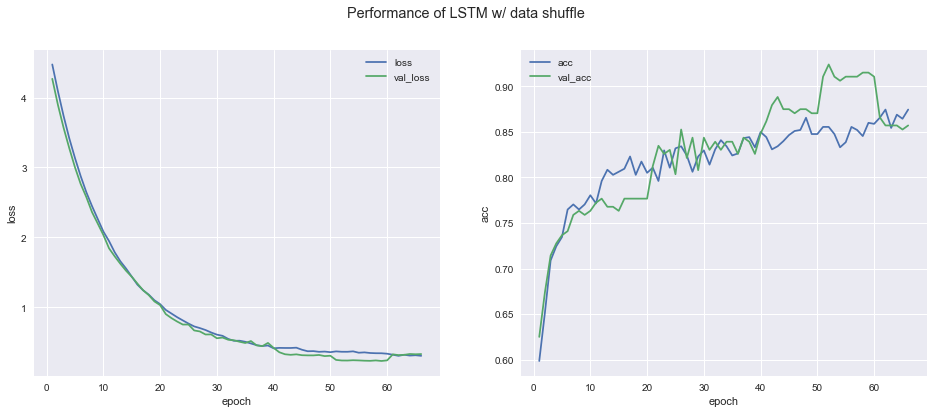

In [69]:
plot_history(history, 'Performance of LSTM w/ data shuffle', dictionary=True)

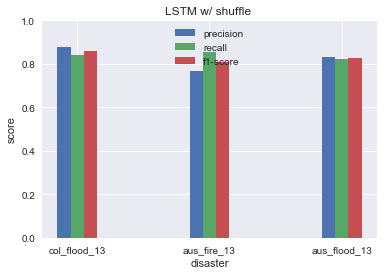

In [70]:
p, r, f = metric_drawing('LSTM w/ shuffle ', path='lstm_shuffle.h5')

In [71]:
print p, r, f

[0.87782805429864252, 0.76523031203566116, 0.833587786259542] [0.84225759768451525, 0.85548172757475083, 0.82105263157894737] [0.85967503692762182, 0.80784313725490187, 0.82727272727272738]


In [77]:
increment_learning_result(path='lstm_shuffle.h5')

no incremental learning:
917/917 [==============================] - 14s 16ms/step
[0.505985929115778, 0.79280261762009585]
1079/1079 [==============================] - 2s 2ms/step
[0.53123498664507718, 0.77293790552326658]
1112/1112 [==============================] - 2s 2ms/step
[0.50311253225203045, 0.79496402877697847]
hard label:
917/917 [==============================] - 15s 16ms/step
[0.49773429439788036, 0.79716466778367268]
1079/1079 [==============================] - 14s 13ms/step
[0.54111429714736725, 0.77571825770120917]
1112/1112 [==============================] - 18s 16ms/step
[0.50089522360040128, 0.80125899280575541]
labels with weight:
917/917 [==============================] - 15s 16ms/step
[0.4969437696941546, 0.79825518032456688]
1079/1079 [==============================] - 17s 15ms/step
[0.54252874751793667, 0.7775718260408]
1112/1112 [==============================] - 15s 14ms/step
[0.50150057126721037, 0.80035971223021585]


## 640 batch size

In [49]:
%%time
from keras.callbacks import ReduceLROnPlateau
model = create_lstm_model(n_lstm=64, initial_lr=0.01)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_640_batch.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0.0001)
history = model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp, rlr], batch_size=640, epochs=100, validation_split=0.3)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 27s 35ms/step - loss: 4.6470 - acc: 0.5691 - val_loss: 4.1099 - val_acc: 0.6964
Epoch 2/100
781/781 [==============================] - 2s 2ms/step - loss: 4.0969 - acc: 0.6338 - val_loss: 3.6213 - val_acc: 0.7113
Epoch 3/100
781/781 [==============================] - 2s 2ms/step - loss: 3.5941 - acc: 0.7017 - val_loss: 3.2071 - val_acc: 0.7083
Epoch 4/100
781/781 [==============================] - 2s 3ms/step - loss: 3.1616 - acc: 0.7157 - val_loss: 2.7817 - val_acc: 0.7470
Epoch 5/100
781/781 [==============================] - 2s 2ms/step - loss: 2.7632 - acc: 0.7580 - val_loss: 2.4462 - val_acc: 0.7857
Epoch 6/100
781/781 [==============================] - 2s 3ms/step - loss: 2.4508 - acc: 0.7618 - val_loss: 2.1580 - val_acc: 0.7738
Epoch 7/100
781/781 [==============================] - 2s 3ms/step - loss: 2.1551 - acc: 0.7670 - val_loss: 1.9176 - val_acc: 0.7887
Epoch 8/100
781/781 [

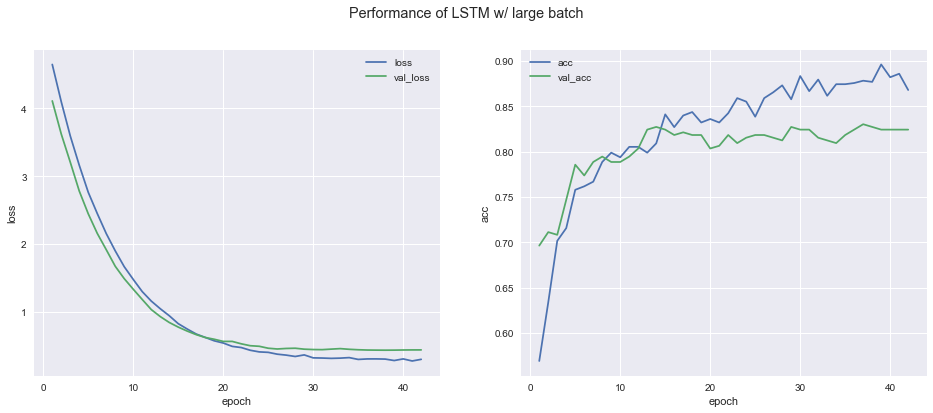

In [55]:
plot_history(history, 'Performance of LSTM w/ large batch')

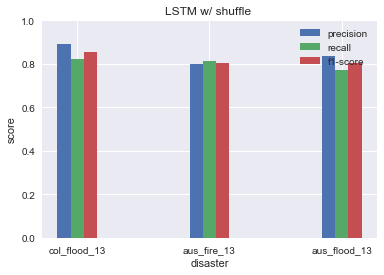

In [124]:
p, r, f = metric_drawing('LSTM w/ shuffle ', path='bi_lstm_640_batch.h5')

In [125]:
print p, r, f

[0.8929133858267716, 0.79804560260586321, 0.83660130718954251] [0.82054992764109991, 0.81395348837209303, 0.76992481203007523] [0.85520361990950222, 0.80592105263157898, 0.8018794048551291]


In [56]:
increment_learning_result(path='bi_lstm_640_batch.h5')

no incremental learning:
917/917 [==============================] - 12s 13ms/step
[0.51381548683411937, 0.78625954224473127]
1079/1079 [==============================] - 2s 2ms/step
[0.52355097293632802, 0.76737720116738151]
1112/1112 [==============================] - 3s 2ms/step
[0.52300362417594992, 0.78147482057269524]
hard label:
917/917 [==============================] - 13s 14ms/step
[0.4936085204911726, 0.82006543094745254]
1079/1079 [==============================] - 12s 11ms/step
[0.56045058068575082, 0.77849860987915165]
1112/1112 [==============================] - 12s 11ms/step
[0.51712590713295148, 0.80125899323456584]
labels with weight:
917/917 [==============================] - 14s 15ms/step
[0.48638592727051694, 0.81025081807940447]
1079/1079 [==============================] - 12s 12ms/step
[0.56979087622106017, 0.77942539393846588]
1112/1112 [==============================] - 13s 12ms/step
[0.51474574058175948, 0.80125899237694498]


## 640 batch size w/shuffle

In [130]:
%%time
model = create_lstm_model(n_lstm=64, initial_lr=0.01)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_640_batch_shuffle.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0.0001)
history = shuffle_train(model, col_fire_12, col_fire_12_g, 'bi_lstm_640_batch_shuffle.h5', val_size=0.2, batch_size=640)

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 25s 28ms/step - loss: 4.5623 - acc: 0.5258 - val_loss: 4.0953 - val_acc: 0.5625
Epoch 2/10
893/893 [==============================] - 2s 2ms/step - loss: 4.0066 - acc: 0.6383 - val_loss: 3.6025 - val_acc: 0.6384
Epoch 3/10
893/893 [==============================] - 2s 2ms/step - loss: 3.5141 - acc: 0.7122 - val_loss: 3.1600 - val_acc: 0.6607
Epoch 4/10
893/893 [==============================] - 2s 2ms/step - loss: 3.0831 - acc: 0.7167 - val_loss: 2.7681 - val_acc: 0.7232
Epoch 5/10
893/893 [==============================] - 2s 2ms/step - loss: 2.7039 - acc: 0.7514 - val_loss: 2.4443 - val_acc: 0.7277
Epoch 6/10
893/893 [==============================] - 2s 2ms/step - loss: 2.3763 - acc: 0.7660 - val_loss: 2.1741 - val_acc: 0.7188
Epoch 7/10
893/893 [==========

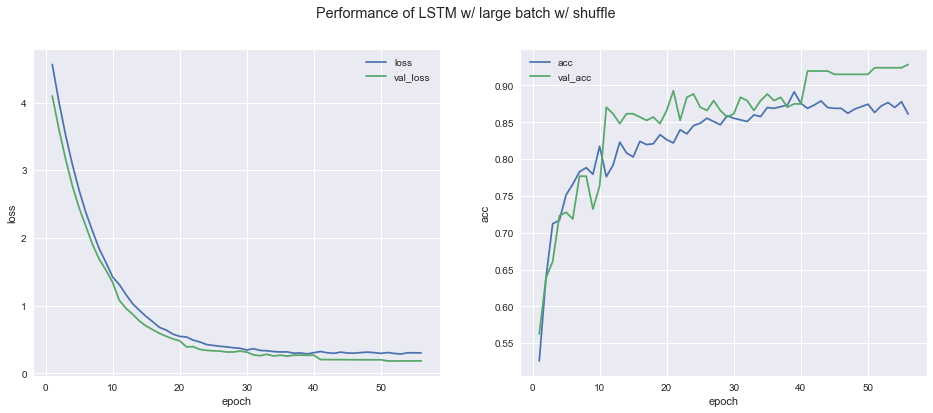

In [131]:
plot_history(history, 'Performance of LSTM w/ large batch w/ shuffle', dictionary=True)

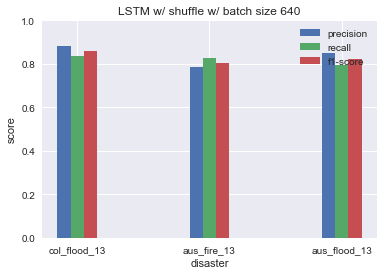

In [132]:
p, r, f = metric_drawing('LSTM w/ shuffle w/ batch size 640', path='bi_lstm_640_batch_shuffle.h5')

In [133]:
print p, r, f

[0.88109756097560976, 0.78459119496855345, 0.84935897435897434] [0.83646888567293776, 0.82890365448504988, 0.79699248120300747] [0.85820341499628805, 0.80613893376413581, 0.82234290147401079]


In [134]:
increment_learning_result(path='bi_lstm_640_batch_shuffle.h5')

no incremental learning:
917/917 [==============================] - 13s 14ms/step
[0.51429502183374431, 0.79171210494920241]
1079/1079 [==============================] - 2s 2ms/step
[0.51292154049298855, 0.77757182537791236]
1112/1112 [==============================] - 2s 2ms/step
[0.51330789923667908, 0.79406474777262848]
hard label:
917/917 [==============================] - 16s 17ms/step
[0.50603311688455399, 0.80043620527635617]
1079/1079 [==============================] - 13s 12ms/step
[0.51612330886144342, 0.77757182537791236]
1112/1112 [==============================] - 13s 12ms/step
[0.50740728489786602, 0.79136690690363054]
labels with weight:
917/917 [==============================] - 14s 16ms/step
[0.50159117748459137, 0.80043620527635617]
1079/1079 [==============================] - 14s 13ms/step
[0.5156450741704246, 0.77664504131859824]
1112/1112 [==============================] - 16s 15ms/step
[0.50659175249312416, 0.7922661874791701]


## 640 batch size w/ shuffle w/o regularization

In [136]:
%%time
model = create_lstm_model(n_lstm=64, penalty=0, initial_lr=0.01)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_640_batch_shuffle_no_re.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0.0001)
history = shuffle_train(model, col_fire_12, col_fire_12_g, 'bi_lstm_640_batch_shuffle_no_re.h5', val_size=0.2, batch_size=640)

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 29s 32ms/step - loss: 0.6999 - acc: 0.5218 - val_loss: 0.6818 - val_acc: 0.5580
Epoch 2/10
893/893 [==============================] - 2s 2ms/step - loss: 0.6342 - acc: 0.6271 - val_loss: 0.5626 - val_acc: 0.7009
Epoch 3/10
893/893 [==============================] - 2s 2ms/step - loss: 0.5843 - acc: 0.7044 - val_loss: 0.5163 - val_acc: 0.7366
Epoch 4/10
893/893 [==============================] - 2s 2ms/step - loss: 0.5404 - acc: 0.7156 - val_loss: 0.5681 - val_acc: 0.7143
Epoch 5/10
893/893 [==============================] - 2s 2ms/step - loss: 0.5166 - acc: 0.7335 - val_loss: 0.5003 - val_acc: 0.7679
Epoch 6/10
893/893 [==============================] - 2s 2ms/step - loss: 0.4868 - acc: 0.7704 - val_loss: 0.4478 - val_acc: 0.7857
Epoch 7/10
893/893 [==========

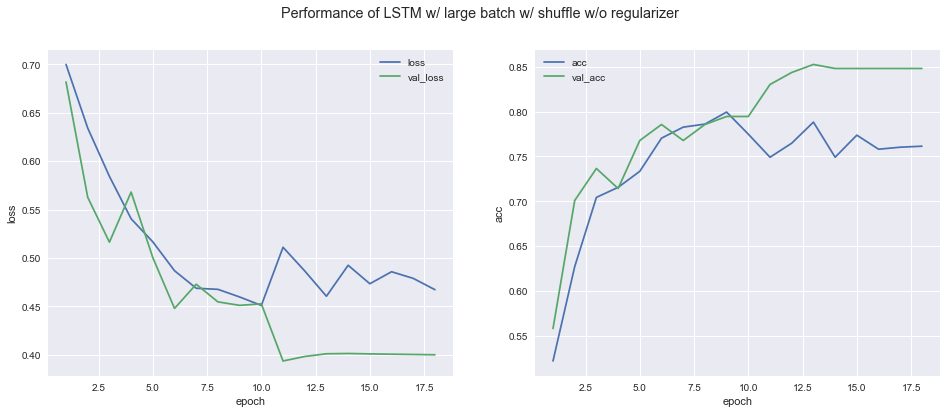

In [137]:
plot_history(history, 'Performance of LSTM w/ large batch w/ shuffle w/o regularizer', dictionary=True)

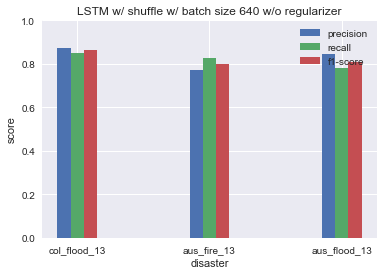

In [138]:
p, r, f = metric_drawing('LSTM w/ shuffle w/ batch size 640 w/o regularizer', path='bi_lstm_640_batch_shuffle_no_re.h5')

In [140]:
print p, r, f

[0.8736998514115899, 0.77006172839506171, 0.84502446982055468] [0.85094066570188132, 0.82890365448504988, 0.77894736842105261] [0.8621700879765396, 0.7984, 0.81064162754303604]


In [139]:
increment_learning_result(path='bi_lstm_640_batch_shuffle_no_re.h5')

no incremental learning:
917/917 [==============================] - 17s 18ms/step
[0.44385800457832725, 0.7949836426368847]
1079/1079 [==============================] - 2s 2ms/step
[0.48874511881157467, 0.76645041650042034]
1112/1112 [==============================] - 2s 2ms/step
[0.46939540230970589, 0.78237410029061405]
hard label:
917/917 [==============================] - 14s 15ms/step
[0.43810912475981134, 0.79716466765367344]
1079/1079 [==============================] - 17s 16ms/step
[0.49558755338357707, 0.76737720160930656]
1112/1112 [==============================] - 17s 15ms/step
[0.46365986003292553, 0.78507194201723274]
labels with weight:
917/917 [==============================] - 15s 16ms/step
[0.43677284842359071, 0.80043620527635617]
1079/1079 [==============================] - 17s 16ms/step
[0.49388319066103353, 0.76830398566862079]
1112/1112 [==============================] - 15s 14ms/step
[0.46424988877001427, 0.78417266144169318]


## 640 batch size w/ shuffle w/o regularization w/dense

In [16]:
%%time
from keras.layers import Dropout
model = create_lstm_model(n_lstm=64, penalty=0, initial_lr=0.01, dense=True)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_640_batch_shuffle_no_re_dense.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0.0001)
history = shuffle_train(model, col_fire_12, col_fire_12_g, 'bi_lstm_640_batch_shuffle_no_re_dense.h5', val_size=0.2, batch_size=640)

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 6s 6ms/step - loss: 0.7049 - acc: 0.5515 - val_loss: 0.6356 - val_acc: 0.6473
Epoch 2/10
893/893 [==============================] - 2s 2ms/step - loss: 0.6206 - acc: 0.6506 - val_loss: 0.5593 - val_acc: 0.6964
Epoch 3/10
893/893 [==============================] - 2s 2ms/step - loss: 0.6154 - acc: 0.6730 - val_loss: 0.5174 - val_acc: 0.7500
Epoch 4/10
893/893 [==============================] - 2s 2ms/step - loss: 0.5367 - acc: 0.7335 - val_loss: 0.4657 - val_acc: 0.7500
Epoch 5/10
893/893 [==============================] - 2s 2ms/step - loss: 0.5308 - acc: 0.7458 - val_loss: 0.4908 - val_acc: 0.7812
Epoch 6/10
893/893 [==============================] - 2s 2ms/step - loss: 0.5039 - acc: 0.7660 - val_loss: 0.4764 - val_acc: 0.7723
Epoch 7/10
893/893 [============

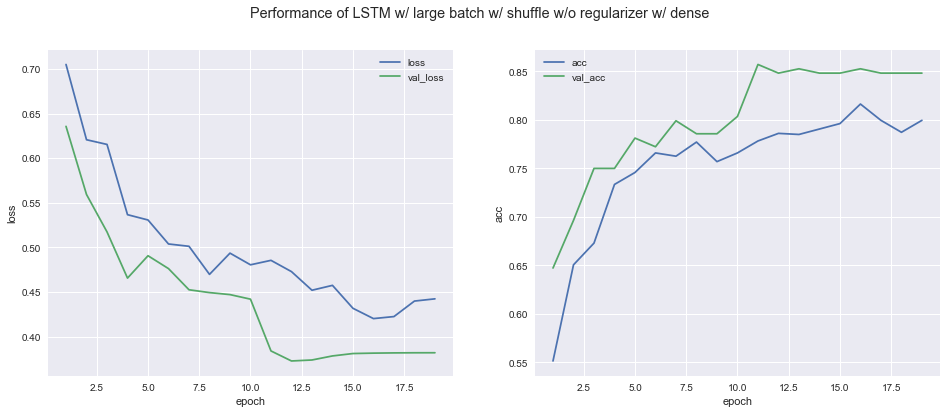

In [18]:
plot_history(history, 'Performance of LSTM w/ large batch w/ shuffle w/o regularizer w/ dense', dictionary=True)

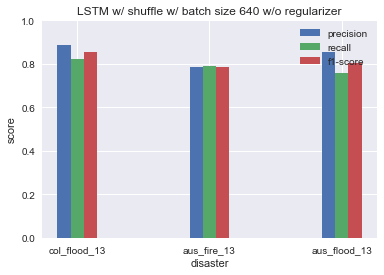

In [19]:
p, r, f = metric_drawing('LSTM w/ shuffle w/ batch size 640 w/o regularizer', path='bi_lstm_640_batch_shuffle_no_re_dense.h5')

In [20]:
print p, r, f

[0.88767550702028086, 0.78382838283828382, 0.85279187817258884] [0.8234442836468886, 0.78903654485049834, 0.75789473684210529] [0.85435435435435425, 0.78642384105960261, 0.80254777070063699]


In [21]:
increment_learning_result(path='bi_lstm_640_batch_shuffle_no_re_dense.h5')

no incremental learning:
917/917 [==============================] - 3s 3ms/step
[0.47872525739565802, 0.78844056739151935]
1079/1079 [==============================] - 2s 2ms/step
[0.50215294722388248, 0.76088971297314478]
1112/1112 [==============================] - 2s 2ms/step
[0.49282864454410058, 0.77697841769499743]
hard label:
917/917 [==============================] - 3s 3ms/step
[0.46854714719393781, 0.79716466765367344]
1079/1079 [==============================] - 3s 3ms/step
[0.50847126826630129, 0.76645041710806727]
1112/1112 [==============================] - 3s 3ms/step
[0.48963854381506394, 0.78327338172377448]
labels with weight:
917/917 [==============================] - 3s 3ms/step
[0.46662575324983085, 0.79825518019456765]
1079/1079 [==============================] - 4s 3ms/step
[0.50740492763731415, 0.76645041710806727]
1112/1112 [==============================] - 4s 3ms/step
[0.48770499733283368, 0.78417266229931404]


## 640 batch size w/ shuffle w/dense

In [143]:
%%time
model = create_lstm_model(n_lstm=64, penalty=0.01, initial_lr=0.01, dense=True)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_640_batch_shuffle_dense.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0.0001)
history = shuffle_train(model, col_fire_12, col_fire_12_g, 'bi_lstm_640_batch_shuffle_dense.h5', val_size=0.2, batch_size=640)

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 33s 37ms/step - loss: 5.6226 - acc: 0.5011 - val_loss: 4.9026 - val_acc: 0.6339
Epoch 2/10
893/893 [==============================] - 2s 3ms/step - loss: 4.8174 - acc: 0.6405 - val_loss: 4.1970 - val_acc: 0.7411
Epoch 3/10
893/893 [==============================] - 2s 3ms/step - loss: 4.1679 - acc: 0.6753 - val_loss: 3.6075 - val_acc: 0.7411
Epoch 4/10
893/893 [==============================] - 2s 3ms/step - loss: 3.5859 - acc: 0.6999 - val_loss: 3.0833 - val_acc: 0.7991
Epoch 5/10
893/893 [==============================] - 2s 2ms/step - loss: 3.1072 - acc: 0.7279 - val_loss: 2.6650 - val_acc: 0.8080
Epoch 6/10
893/893 [==============================] - 2s 2ms/step - loss: 2.6847 - acc: 0.7458 - val_loss: 2.3139 - val_acc: 0.8125
Epoch 7/10
893/893 [==========

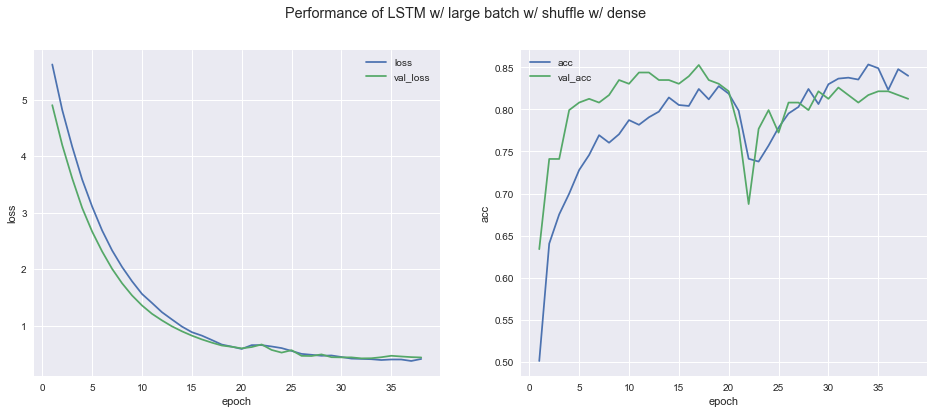

In [144]:
plot_history(history, 'Performance of LSTM w/ large batch w/ shuffle w/ dense', dictionary=True)

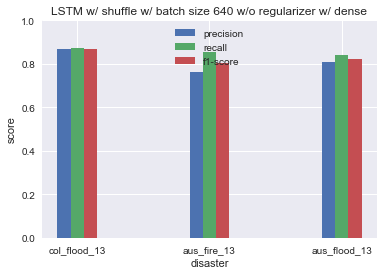

In [145]:
p, r, f = metric_drawing('LSTM w/ shuffle w/ batch size 640 w/ dense', path='bi_lstm_640_batch_shuffle_dense.h5')

In [146]:
print p, r, f

[0.86762589928057554, 0.76183431952662717, 0.80635838150289019] [0.87264833574529665, 0.85548172757475083, 0.83909774436090223] [0.87012987012987009, 0.80594679186228468, 0.82240235814296236]


In [147]:
increment_learning_result(path='bi_lstm_640_batch_shuffle_dense.h5')

no incremental learning:
917/917 [==============================] - 16s 17ms/step
[0.50568794726415445, 0.80370774289903879]
1079/1079 [==============================] - 2s 2ms/step
[0.53072996643320958, 0.77015755312436152]
1112/1112 [==============================] - 2s 2ms/step
[0.54011925068690625, 0.78327338086615361]
hard label:
917/917 [==============================] - 16s 18ms/step
[0.50367032246605259, 0.80152671781725038]
1079/1079 [==============================] - 14s 13ms/step
[0.54311132878479418, 0.772937905302304]
1112/1112 [==============================] - 16s 14ms/step
[0.54774827837086415, 0.78776978374385143]
labels with weight:
917/917 [==============================] - 16s 17ms/step
[0.49824438808788518, 0.804798255439933]
1079/1079 [==============================] - 16s 15ms/step
[0.54490244626115047, 0.772937905302304]
1112/1112 [==============================] - 17s 15ms/step
[0.54131165511316537, 0.78956834489493066]


## Some Error Analysis

In [67]:
model = load_model("bi_lstm_640_batch.h5")
incremental_learning_det(model, aus_fire_13_g, step=10, confidence=0.9)
y = model.predict(aus_fire_13_g)
y_pred=[]
for t in y:
    if t[0]>t[1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
y_pred = np.array(y_pred)
cl = {'tp':[1,1], 'tn':[0,0], 'fp':[1,0], 'fn':[0,1]}
for d in cl.keys():
    f = open('aus_fire_{}_LSTM_inc.txt'.format(d),'w')
    for tweet in aus_fire_13.df.TweetText[y_pred==cl[d][0]][aus_fire_13.df.label==cl[d][1]]:
        f.write(tweet + '\n' + '\n')
    f.close()

In [57]:
model = load_model("bi_lstm_640_batch.h5")
y = model.predict(col_flood_13_g)
y_pred=[]
for t in y:
    if t[0]>t[1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
cl = {'tp':[1,1], 'tn':[0,0], 'fp':[1,0], 'fn':[0,1]}
y_pred = np.array(y_pred)
for d in cl.keys():
    f = open('col_flood_{}_LSTM.txt'.format(d),'w')
    for tweet in col_flood_13.df.TweetText[y_pred==cl[d][0]][col_flood_13.df.label==cl[d][1]]:
        f.write(tweet + '\n' + '\n')
    f.close()

In [58]:
fn_lr = []
f = open('logistic_regression_classified_tweets/col_flood_13/col_flood_fn_lr.txt')
for line in f.readlines():
    fn_lr.append(line)

f.close()
fn_lstm = []
f = open('lstm_classified_tweets/col_flood_13/col_flood_fn_LSTM.txt')
for line in f.readlines():
    fn_lstm.append(line)
f.close()
set(fn_lr) - set(fn_lstm)

{"#2030NOW People losing homes in Colorado didn't have flood insurance because they had never experienced #floods. #climatechange\n",
 '#90sBabyFollowTrain Officials: 201 remain unaccounted for in Colorado floods; property lo... http://t.co/8wCbMwn8HF #TeamFollowWack #TFB\n',
 '#Breaking: Jamestown, Colorado, is under mandatory evacuation order due to flash flooding - @dailycamera http://t.co/bN3gBLKHQg\n',
 '#BreakingNews Drake man previously called missing, presumed dead in #COFlood by @LarimerSheriff was found alive. http://t.co/QnvNFXONuY\n',
 '#Colorado Floods Leave #Hundreds Unaccounted For http://t.co/LcRtx5HIYt\n',
 '#Colorado braces for more heavy rain, devastating floods http://t.co/vy2io8d86Y\n',
 '#Colorado flooding kills two. @ryanparkerdp  http://t.co/Pqi3EpjGj3 \xe2\x80\xa6\n',
 '#Colorado floods triggered by convergence of geography and climate, experts say http://t.co/LZ2IaZNcf4\n',
 '#DEVELOPING | 1 Dead as Flash Flooding Hits Parts of Colorado http://t.co/RDMF3TkiQH 

In [64]:
set(fn_lstm)

{'\n',
 '#AWWA offers support and resources to flooded communities in Colorado. http://t.co/1cHErygsvN #coflood\n',
 '#Boulder #Colorado has like 340 days of sunshine a year. Now the #BoulderFlood ? That just proves if we are gonna do it, we do it big!\n',
 '#COFLOOD Affected Pets Need Your Help!  http://t.co/EIrPg7SpFB via @amyshojai\n',
 '#CruzRoja: Misi\xc3\xb3n, Visi\xc3\xb3n y Principales Objectivos \xe2\x98\x91 http://t.co/pyY244b4sW | #RedCross #COFlood #cofloods #coflooding #CO #COFloodRelief\n',
 '#Jamestown resident says things are disappearing from lumberyards around town. Worried about more looters. They will come. #boulderflood\n',
 '#Political News Hickenlooper considering special legislative session in wake of Colorado floods http://t.co/SODvrp0LO1\n',
 '#Presbyterian Disaster Assistance responds to the #Colorado flooding. Learn what you can do to help: http://t.co/AZTWbHTD3z\n',
 '#coloradoflood : Stories of grief, generosity http://t.co/MNwzbuoZKA\n',
 "#lyons #boulder

In [70]:
fn_wo_inc = []
f = open('aus_fire_fn_lr.txt')
for line in f.readlines():
    fn_wo_inc.append(line)

f.close()
fn_w_inc = []
f = open('aus_fire_fn_LSTM_inc.txt')
for line in f.readlines():
    fn_w_inc.append(line)
f.close()
set(fn_wo_inc) - set(fn_w_inc)

{'#NSWfires For Newcastle people summary of fires situation from Newcastle Herald at http://t.co/4y7FwVGsH2\n',
 "2.05 Live Media briefing available at http://t.co/znwR7Ulp7E or download the 'livestream' app and follow nswrfs #nswrfs #nswfires\n",
 '@Fridayology the rain has completely brown past us here in Sydney we could really use it with the fires to put them out for good\n',
 '@Sandra_Sully: .@_AdamTodd: Bushfires at Springwood as the sun sets #nswfires #eyewitnessnews http://t.co/stbzJlm5Uy\n',
 '@nswrfs thanks @QantasAirways . Their staff in groups helping to take our interstate colleagues home today and tomorrow #nswfires\n',
 '@thetodayshow   People are still throwing cigarette buts out of car windows, it is truly disgusting.  #nswfires\n',
 'Amazing and terrifying RT @workmanalice: Amazing photo from a friend in Katoomba on the road to Blackheath. #nswfires http://t.co/17TQTT40Af\n',
 'C10 Fire Safety Engineer Sydney http://t.co/kMMqf3il87  #ENGJobs\n',
 'Congratulations to t

In [72]:
set(fn_w_inc) - set(fn_wo_inc)

set()

In [73]:
fp_wo_inc = []
f = open('aus_fire_fp_lr.txt')
for line in f.readlines():
    fp_wo_inc.append(line)

f.close()
fp_w_inc = []
f = open('aus_fire_fp_LSTM_inc.txt')
for line in f.readlines():
    fp_w_inc.append(line)
f.close()
set(fp_wo_inc) - set(fp_w_inc)

set()

In [74]:
set(fp_w_inc) - set(fp_wo_inc)

{'#3 READ IT !!! Proves #REDOCTOBER was not for racist reasons!! Drop the shit people lets make our country for every1 http://t.co/4Ddxrf0ijn\n',
 "#AJstream I'm black, African, I understand #RedOctober and its not only happening in South Africa, with less violence though.\n",
 '#Cardinals play the #RedSox tonight at 8:07 ET @ Busch Stadium in Game 3 of the #WorldSeries! #GoCards #RedOctober\n',
 "#ThisIsOctober RT PAPERCHASER_314: Can't wait for game 1 tonight #REDBIRDS #RedOctober #thisiswhatwedo\n",
 '#Winmalee #Faulconbridge #Springwood @LegalAidNSW Guide2get your #InsuranceClaim paid http://t.co/wPCiO5QD5F #RedOctober2013\n',
 "#nswfires People queuing for over an hour at Blaxland tip. C'mon Blue Mtns council open up the tip!\n",
 '@Trevornoah u still think #RedOctober was an over-reaction? Easy to make fun of a minority, easy to kill them too http://t.co/9P0xhiNrZp\n',
 '@Wells_P chillin outside HoH for the 10/32/13 release of the #RedOctober\n',
 '@nettynet67 @AdamBandt are you 

In [83]:
triple = pd.concat([col_flood_13.df, aus_flood_13.df, aus_fire_13.df]).sample(frac=1).reset_index(drop=True)
triple.to_csv('triple.csv')

In [84]:
triple = dataset('triple.csv')

In [85]:
triple_g=triple.glove(embedding_index, vtr_dim)

In [87]:
model = load_model('lstm_shuffle.h5')
incremental_learning_det(model, triple_g, step=10, confidence=0.9)
model.evaluate(triple_g,to_categorical(triple.df.label))

3108/3108 [==============================] - 11s 4ms/step


[0.62065968435243291, 0.79633204633204635]

In [86]:
model = load_model('lstm_shuffle.h5')
model.evaluate(triple_g,to_categorical(triple.df.label))

3108/3108 [==============================] - 11s 4ms/step


[0.51479478941767676, 0.78861003861003864]

In [88]:
model = load_model('lstm_shuffle.h5')
incremental_learning_prob(model, triple_g, step=10, threshold=0.9)
model.evaluate(triple_g,to_categorical(triple.df.label))

3108/3108 [==============================] - 13s 4ms/step


[0.59693224994679062, 0.79794079794079797]

## w/shuffle w/o regularization

In [91]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0, dropout=0.3, re_dropout=0.3)
history=shuffle_train(lstm_model, col_fire_12, col_fire_12_g, 'lstm_shuffle_2.h5')

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 21s 24ms/step - loss: 0.6887 - acc: 0.5543 - val_loss: 0.6716 - val_acc: 0.5670
Epoch 2/10
893/893 [==============================] - 6s 6ms/step - loss: 0.6396 - acc: 0.6585 - val_loss: 0.6294 - val_acc: 0.6741
Epoch 3/10
893/893 [==============================] - 5s 6ms/step - loss: 0.6035 - acc: 0.6954 - val_loss: 0.6129 - val_acc: 0.6518
Epoch 4/10
893/893 [==============================] - 5s 5ms/step - loss: 0.5762 - acc: 0.7066 - val_loss: 0.5632 - val_acc: 0.7188
Epoch 5/10
893/893 [==============================] - 5s 5ms/step - loss: 0.5524 - acc: 0.7212 - val_loss: 0.5400 - val_acc: 0.7232
Epoch 6/10
893/893 [==============================] - 5s 5ms/step - loss: 0.5415 - acc: 0.7279 - val_loss: 0.5103 - val_acc: 0.7455
Epoch 7/10
893/893 [==========

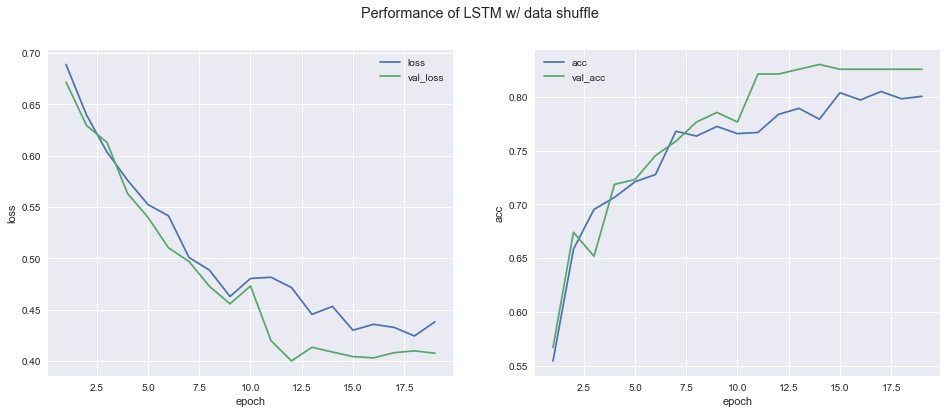

In [92]:
plot_history(history, 'Performance of LSTM w/ data shuffle', dictionary=True)

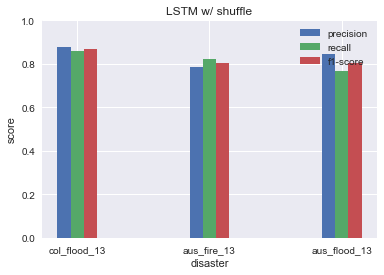

In [93]:
p, r, f = metric_drawing('LSTM w/ shuffle', path='lstm_shuffle_2.h5')

In [94]:
print p, r, f

[0.8775811209439528, 0.78412698412698412, 0.84411276948590386] [0.86107091172214179, 0.82059800664451832, 0.76541353383458643] [0.86924762600438266, 0.80194805194805185, 0.80283911671924291]


In [95]:
increment_learning_result(path='lstm_shuffle_2.h5')

no incremental learning:
917/917 [==============================] - 9s 10ms/step
[0.4433752932751322, 0.80479825550493267]
1079/1079 [==============================] - 2s 2ms/step
[0.48501824012390432, 0.77386469002450586]
1112/1112 [==============================] - 2s 2ms/step
[0.48750661109848847, 0.7751798565439183]
hard label:
917/917 [==============================] - 9s 9ms/step
[0.43654806520322675, 0.81243184329119222]
1079/1079 [==============================] - 9s 8ms/step
[0.49030283112786677, 0.77757182626176258]
1112/1112 [==============================] - 8s 7ms/step
[0.48272640156231339, 0.77787769784172667]
labels with weight:
917/917 [==============================] - 8s 9ms/step
[0.43794786731835411, 0.81134133075029791]
1079/1079 [==============================] - 9s 8ms/step
[0.48821904429470198, 0.77479147408381999]
1112/1112 [==============================] - 11s 10ms/step
[0.48292983778946691, 0.77877697841726623]


## w/shuffle (k=20) w/o regularization

In [97]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0, dropout=0.3, re_dropout=0.3)
history=shuffle_train(lstm_model, col_fire_12, col_fire_12_g, 'lstm_shuffle_3.h5', k=20, n_epoch=5, earlystop=4)

Train on 893 samples, validate on 224 samples
Epoch 1/5
893/893 [==============================] - 19s 21ms/step - loss: 0.7132 - acc: 0.4961 - val_loss: 0.6690 - val_acc: 0.5893
Epoch 2/5
893/893 [==============================] - 5s 5ms/step - loss: 0.6729 - acc: 0.5767 - val_loss: 0.6294 - val_acc: 0.6786
Epoch 3/5
893/893 [==============================] - 5s 5ms/step - loss: 0.6455 - acc: 0.6293 - val_loss: 0.5924 - val_acc: 0.7188
Epoch 4/5
893/893 [==============================] - 5s 5ms/step - loss: 0.6126 - acc: 0.6809 - val_loss: 0.5555 - val_acc: 0.7411
Epoch 5/5
893/893 [==============================] - 5s 5ms/step - loss: 0.5811 - acc: 0.7111 - val_loss: 0.5062 - val_acc: 0.7768
Train on 893 samples, validate on 224 samples
Epoch 1/5
893/893 [==============================] - 5s 5ms/step - loss: 0.5346 - acc: 0.7402 - val_loss: 0.4943 - val_acc: 0.7634
Epoch 2/5
893/893 [==============================] - 5s 5ms/step - loss: 0.4900 - acc: 0.7648 - val_loss: 0.4725 - val_a

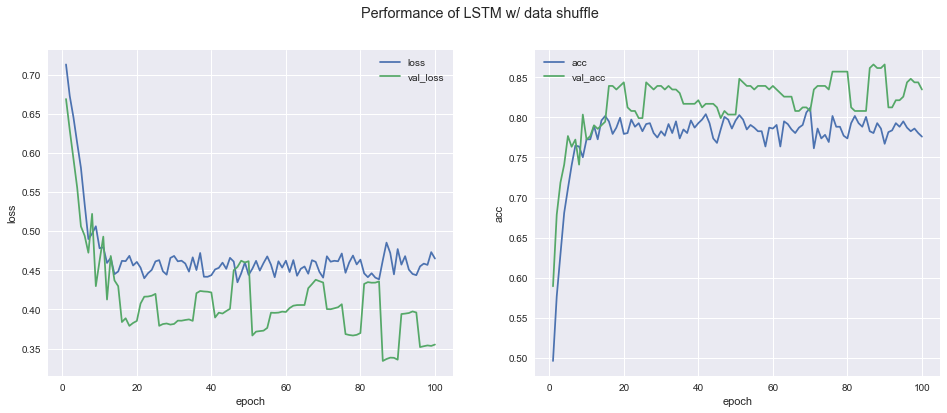

In [98]:
plot_history(history, 'Performance of LSTM w/ data shuffle', dictionary=True)

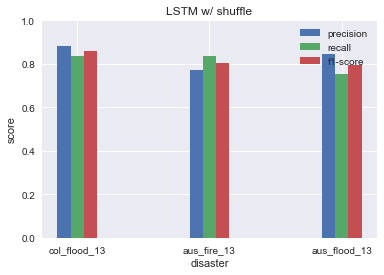

In [100]:
p, r, f = metric_drawing('LSTM w/ shuffle', path='lstm_shuffle_3.h5')

In [101]:
print p, r, f

[0.88226299694189603, 0.77230769230769236, 0.84602368866328259] [0.83502170767004347, 0.83388704318936879, 0.75187969924812026] [0.85799256505576205, 0.80191693290734833, 0.79617834394904452]


In [99]:
increment_learning_result(path='lstm_shuffle_3.h5')

no incremental learning:
917/917 [==============================] - 10s 11ms/step
[0.46582845015900215, 0.79171210501420197]
1079/1079 [==============================] - 2s 2ms/step
[0.50445298705529684, 0.77015755378724915]
1112/1112 [==============================] - 2s 2ms/step
[0.51233188797244067, 0.76978417223306006]
hard label:
917/917 [==============================] - 10s 11ms/step
[0.45401575095390934, 0.80261723048814382]
1079/1079 [==============================] - 9s 9ms/step
[0.51003220928720683, 0.76645041754999244]
1112/1112 [==============================] - 10s 9ms/step
[0.50215160417899807, 0.77787769741291624]
labels with weight:
917/917 [==============================] - 9s 10ms/step
[0.45471448492717848, 0.80261723048814382]
1079/1079 [==============================] - 9s 8ms/step
[0.50884038193342973, 0.76830398566862079]
1112/1112 [==============================] - 9s 8ms/step
[0.50496534134844229, 0.77607913626183711]


## w/o regularization w/dense

In [108]:
%%time
from keras.layers import Dropout
lstm_model = create_lstm_model(n_lstm=64, penalty=0, dropout=0.3, re_dropout=0.3, dense=True)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_dense.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 23s 30ms/step - loss: 0.7143 - acc: 0.5122 - val_loss: 0.6725 - val_acc: 0.5863
Epoch 2/100
781/781 [==============================] - 6s 8ms/step - loss: 0.6693 - acc: 0.5967 - val_loss: 0.6247 - val_acc: 0.6667
Epoch 3/100
781/781 [==============================] - 6s 7ms/step - loss: 0.6377 - acc: 0.6364 - val_loss: 0.5936 - val_acc: 0.7054
Epoch 4/100
781/781 [==============================] - 6s 7ms/step - loss: 0.6226 - acc: 0.6581 - val_loss: 0.5627 - val_acc: 0.7232
Epoch 5/100
781/781 [==============================] - 5s 6ms/step - loss: 0.6007 - acc: 0.6697 - val_loss: 0.5398 - val_acc: 0.7321
Epoch 6/100
781/781 [==============================] - 5s 6ms/step - loss: 0.5720 - acc: 0.7055 - val_loss: 0.5186 - val_acc: 0.7381
Epoch 7/100
781/781 [==============================] - 5s 6ms/step - loss: 0.5463 - acc: 0.7196 - val_loss: 0.4845 - val_acc: 0.7649
Epoch 8/100
781/781 [

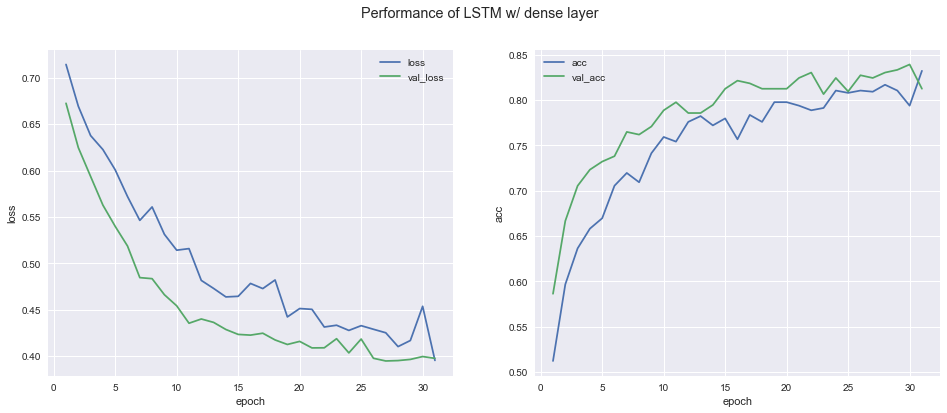

In [110]:
plot_history(history, 'Performance of LSTM w/ dense layer')

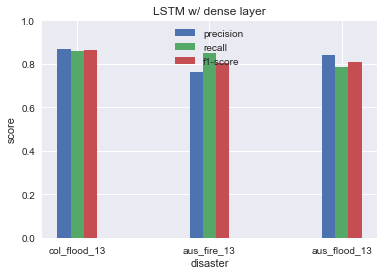

In [111]:
p, r, f = metric_drawing('LSTM w/ dense layer', path='bi_lstm_dense.h5')

In [112]:
print p, r, f

[0.86822840409956081, 0.76190476190476186, 0.83896940418679544] [0.8581765557163531, 0.85049833887043191, 0.7834586466165413] [0.86317321688500737, 0.8037676609105181, 0.81026438569206838]


In [113]:
increment_learning_result(path='bi_lstm_dense.h5')

no incremental learning:
917/917 [==============================] - 9s 9ms/step
[0.45808559129646326, 0.7949836426368847]
1079/1079 [==============================] - 2s 2ms/step
[0.48330472825410964, 0.76830398522669574]
1112/1112 [==============================] - 2s 2ms/step
[0.47737931733508759, 0.78057553999715568]
hard label:
917/917 [==============================] - 9s 10ms/step
[0.51263831550968386, 0.80370774283403923]
1079/1079 [==============================] - 10s 9ms/step
[0.81204651101415526, 0.67562557951624025]
1112/1112 [==============================] - 10s 9ms/step
[0.55886491254079251, 0.79316546805470967]
labels with weight:
917/917 [==============================] - 9s 10ms/step
[0.52111967146851634, 0.79825518012956809]
1079/1079 [==============================] - 10s 9ms/step
[0.73293016899283892, 0.68767377228732463]
1112/1112 [==============================] - 10s 9ms/step
[0.52286459216111003, 0.79316546719708891]


## w/shuffle w/dense w/o regularization

In [114]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0, dropout=0.3, re_dropout=0.3, dense=True)
history=shuffle_train(lstm_model, col_fire_12, col_fire_12_g, 'lstm_shuffle_dense.h5')

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 27s 30ms/step - loss: 0.6869 - acc: 0.5386 - val_loss: 0.6187 - val_acc: 0.6562
Epoch 2/10
893/893 [==============================] - 6s 7ms/step - loss: 0.6336 - acc: 0.6540 - val_loss: 0.5811 - val_acc: 0.6964
Epoch 3/10
893/893 [==============================] - 5s 6ms/step - loss: 0.6069 - acc: 0.6831 - val_loss: 0.5423 - val_acc: 0.7411
Epoch 4/10
893/893 [==============================] - 5s 5ms/step - loss: 0.5791 - acc: 0.6898 - val_loss: 0.5212 - val_acc: 0.7366
Epoch 5/10
893/893 [==============================] - 5s 5ms/step - loss: 0.5663 - acc: 0.7044 - val_loss: 0.4933 - val_acc: 0.7768
Epoch 6/10
893/893 [==============================] - 5s 6ms/step - loss: 0.5412 - acc: 0.7279 - val_loss: 0.4751 - val_acc: 0.7857
Epoch 7/10
893/893 [==========

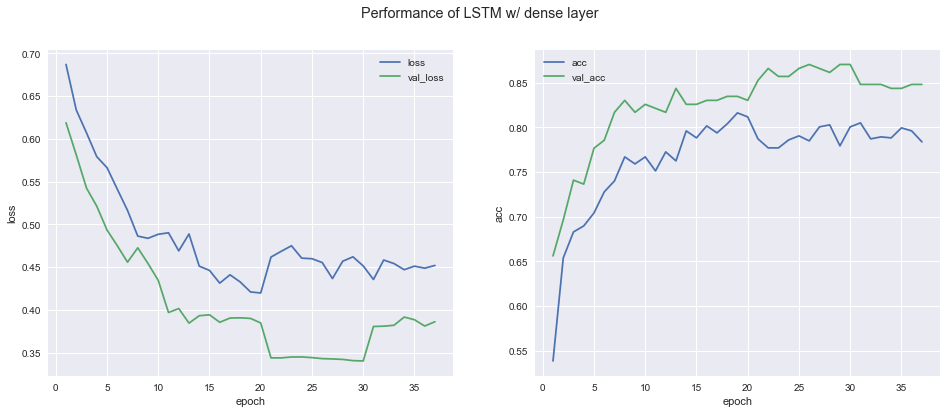

In [117]:
plot_history(history, 'Performance of LSTM w/ dense layer', dictionary=True)

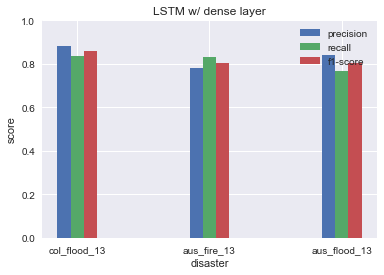

In [119]:
p, r, f = metric_drawing('LSTM w/ dense layer', path='lstm_shuffle_dense.h5')

In [120]:
print p, r, f

[0.88244274809160306, 0.78003120124804992, 0.83908045977011492] [0.83646888567293776, 0.83056478405315615, 0.76842105263157889] [0.85884101040118876, 0.80450522928399038, 0.80219780219780212]


In [121]:
increment_learning_result(path='lstm_shuffle_dense.h5')

no incremental learning:
917/917 [==============================] - 10s 11ms/step
[0.45181468275407149, 0.79280261749009662]
1079/1079 [==============================] - 2s 2ms/step
[0.48503048244287172, 0.774791473034248]
1112/1112 [==============================] - 2s 2ms/step
[0.47113042019254014, 0.77338129496402874]
hard label:
917/917 [==============================] - 12s 13ms/step
[0.43963405223423158, 0.8058887679808272]
1079/1079 [==============================] - 12s 11ms/step
[0.49673933000670639, 0.77201112085630541]
1112/1112 [==============================] - 11s 10ms/step
[0.46416768924795465, 0.78327338129496404]
labels with weight:
917/917 [==============================] - 10s 11ms/step
[0.43912851976204337, 0.8058887679808272]
1079/1079 [==============================] - 11s 10ms/step
[0.49200306632543073, 0.77108433679699129]
1112/1112 [==============================] - 11s 10ms/step
[0.4646228774846029, 0.78057553956834536]


## w/shuffle w/dense

In [148]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0.01, dropout=0.3, re_dropout=0.3, dense=True)
history=shuffle_train(lstm_model, col_fire_12, col_fire_12_g, 'lstm_shuffle_dense_re.h5')

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 54s 60ms/step - loss: 5.3864 - acc: 0.5459 - val_loss: 5.1280 - val_acc: 0.5000
Epoch 2/10
893/893 [==============================] - 5s 5ms/step - loss: 4.8697 - acc: 0.5834 - val_loss: 4.6077 - val_acc: 0.6205
Epoch 3/10
893/893 [==============================] - 5s 5ms/step - loss: 4.4074 - acc: 0.6540 - val_loss: 4.1575 - val_acc: 0.6830
Epoch 4/10
893/893 [==============================] - 5s 5ms/step - loss: 3.9963 - acc: 0.6708 - val_loss: 3.8102 - val_acc: 0.6384
Epoch 5/10
893/893 [==============================] - 5s 5ms/step - loss: 3.6332 - acc: 0.6865 - val_loss: 3.4236 - val_acc: 0.6920
Epoch 6/10
893/893 [==============================] - 5s 5ms/step - loss: 3.2922 - acc: 0.7234 - val_loss: 3.1196 - val_acc: 0.7143
Epoch 7/10
893/893 [==========

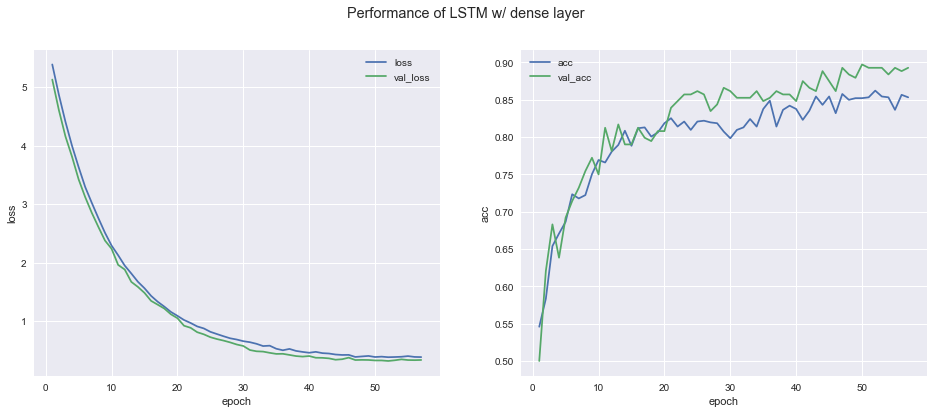

In [149]:
plot_history(history, 'Performance of LSTM w/ dense layer', dictionary=True)

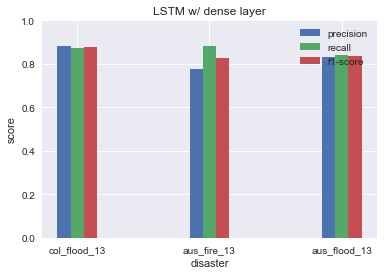

In [150]:
p, r, f = metric_drawing('LSTM w/ dense layer', path='lstm_shuffle_dense_re.h5')

In [151]:
print p, r, f

[0.88157894736842102, 0.77598828696925326, 0.83086053412462912] [0.87264833574529665, 0.88039867109634551, 0.84210526315789469] [0.87709090909090914, 0.82490272373540852, 0.83644510828976848]


In [152]:
increment_learning_result(path='lstm_shuffle_dense_re.h5')

no incremental learning:
917/917 [==============================] - 15s 17ms/step
[0.49560527524615322, 0.8157033809788744]
1079/1079 [==============================] - 2s 2ms/step
[0.53154719621633573, 0.79147358648858768]
1112/1112 [==============================] - 2s 2ms/step
[0.50949439706562238, 0.8030575535280241]
hard label:
917/917 [==============================] - 17s 19ms/step
[0.49032319976563282, 0.81025081827440337]
1079/1079 [==============================] - 18s 16ms/step
[0.54159065315964272, 0.7924003705479018]
1112/1112 [==============================] - 16s 15ms/step
[0.50881563995381907, 0.79856115065032629]
labels with weight:
917/917 [==============================] - 17s 18ms/step
[0.4861010449533244, 0.81243184329119222]
1079/1079 [==============================] - 18s 17ms/step
[0.54246002065571952, 0.79054680242927344]
1112/1112 [==============================] - 22s 19ms/step
[0.50831738371643231, 0.80035971180140542]


## 2-LSTM layer

In [24]:
%%time
model = Sequential()
model.add(Bidirectional(LSTM(64, kernel_initializer='he_normal', recurrent_dropout=0.3, dropout=0.3, return_sequences=True, 
                                 kernel_regularizer=regularizers.l2(0.01)),input_shape=(None,25)))
model.add(Bidirectional(LSTM(64, kernel_initializer='he_normal', recurrent_dropout=0.3, dropout=0.3, 
                                 kernel_regularizer=regularizers.l2(0.01))))
optimizer = Adam(lr=0.001)
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history=shuffle_train(model, col_fire_12, col_fire_12_g, '2_lstm_shuffle.h5')

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 14s 16ms/step - loss: 7.9673 - acc: 0.5924 - val_loss: 7.3217 - val_acc: 0.7143
Epoch 2/10
893/893 [==============================] - 10s 11ms/step - loss: 6.8901 - acc: 0.6954 - val_loss: 6.3500 - val_acc: 0.6875
Epoch 3/10
893/893 [==============================] - 11s 12ms/step - loss: 5.9752 - acc: 0.7122 - val_loss: 5.4979 - val_acc: 0.7277
Epoch 4/10
893/893 [==============================] - 10s 11ms/step - loss: 5.2341 - acc: 0.7167 - val_loss: 4.7945 - val_acc: 0.7589
Epoch 5/10
893/893 [==============================] - 10s 12ms/step - loss: 4.5836 - acc: 0.7357 - val_loss: 4.2612 - val_acc: 0.7321
Epoch 6/10
893/893 [==============================] - 10s 11ms/step - loss: 4.0286 - acc: 0.7749 - val_loss: 3.7553 - val_acc: 0.7679
Epoch 7/10
893/893 [

893/893 [==============================] - 12s 13ms/step - loss: 0.4124 - acc: 0.8410 - val_loss: 0.4230 - val_acc: 0.8125
Epoch 10/10
893/893 [==============================] - 12s 14ms/step - loss: 0.3932 - acc: 0.8511 - val_loss: 0.4115 - val_acc: 0.8214
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 10s 12ms/step - loss: 0.4286 - acc: 0.8399 - val_loss: 0.3971 - val_acc: 0.8661
Epoch 2/10
893/893 [==============================] - 11s 12ms/step - loss: 0.4053 - acc: 0.8611 - val_loss: 0.4004 - val_acc: 0.8661
Epoch 3/10
893/893 [==============================] - 11s 12ms/step - loss: 0.4053 - acc: 0.8511 - val_loss: 0.3989 - val_acc: 0.8661
Epoch 4/10
893/893 [==============================] - 11s 12ms/step - loss: 0.4101 - acc: 0.8443 - val_loss: 0.3993 - val_acc: 0.8616
Epoch 5/10
893/893 [==============================] - 10s 12ms/step - loss: 0.4107 - acc: 0.8533 - val_loss: 0.3952 - val_acc: 0.8571
Epoch 6/10
893/893 [======

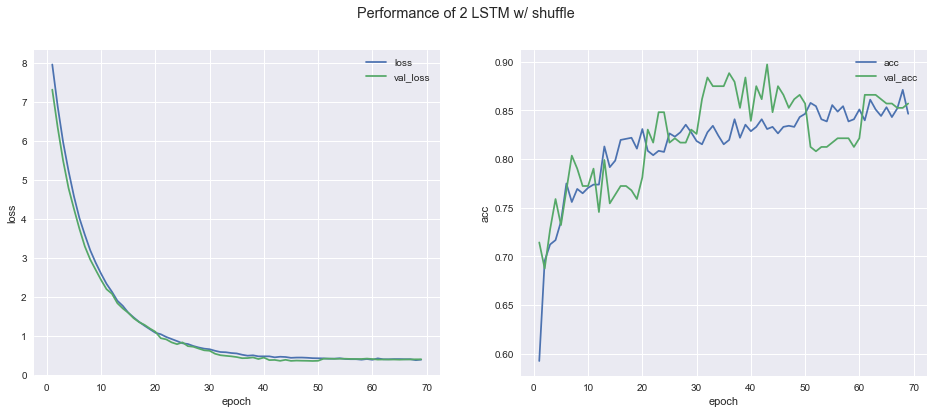

In [25]:
plot_history(history, 'Performance of 2 LSTM w/ shuffle', dictionary=True)

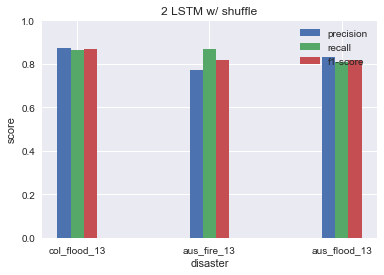

In [26]:
p, r, f = metric_drawing('2 LSTM w/ shuffle', path='2_lstm_shuffle.h5')

In [27]:
print p, r, f

[0.8728070175438597, 0.77058823529411768, 0.83255813953488367] [0.86396526772793059, 0.87043189368770768, 0.80751879699248119] [0.86836363636363634, 0.81747269890795637, 0.81984732824427475]


In [28]:
increment_learning_result(path='2_lstm_shuffle.h5')

no incremental learning:
917/917 [==============================] - 6s 6ms/step
[0.54918411546341073, 0.80261723042314415]
1079/1079 [==============================] - 4s 3ms/step
[0.57290971362005239, 0.7831325301757226]
1112/1112 [==============================] - 4s 3ms/step
[0.56122595682847409, 0.78776978374385143]
hard label:
917/917 [==============================] - 6s 6ms/step
[0.54309741874817541, 0.80806979306261573]
1079/1079 [==============================] - 6s 6ms/step
[0.58383658647095305, 0.78220574611640836]
1112/1112 [==============================] - 7s 6ms/step
[0.55595185666633162, 0.7958633089237076]
labels with weight:
917/917 [==============================] - 6s 7ms/step
[0.53732694027338057, 0.80916030560350993]
1079/1079 [==============================] - 7s 6ms/step
[0.58424737798162252, 0.7831325301757226]
1112/1112 [==============================] - 8s 7ms/step
[0.55066744104134946, 0.79676258949924716]


## 2 LSTM layer w/ 0.1 dropout

In [29]:
%%time
model = Sequential()
model.add(Bidirectional(LSTM(64, kernel_initializer='he_normal', recurrent_dropout=0.1, dropout=0.1, return_sequences=True, 
                                 kernel_regularizer=regularizers.l2(0.01)),input_shape=(None,25)))
model.add(Bidirectional(LSTM(64, kernel_initializer='he_normal', recurrent_dropout=0.1, dropout=0.1, 
                                 kernel_regularizer=regularizers.l2(0.01))))
optimizer = Adam(lr=0.01)
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history=shuffle_train(model, col_fire_12, col_fire_12_g, '2_lstm_shuffle.h5', batch_size=640)

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 14s 15ms/step - loss: 8.5581 - acc: 0.5118 - val_loss: 7.2829 - val_acc: 0.5759
Epoch 2/10
893/893 [==============================] - 6s 6ms/step - loss: 7.0610 - acc: 0.5767 - val_loss: 5.8213 - val_acc: 0.7098
Epoch 3/10
893/893 [==============================] - 5s 5ms/step - loss: 5.6570 - acc: 0.7256 - val_loss: 4.8051 - val_acc: 0.7098
Epoch 4/10
893/893 [==============================] - 4s 5ms/step - loss: 4.6558 - acc: 0.7492 - val_loss: 3.9122 - val_acc: 0.7634
Epoch 5/10
893/893 [==============================] - 4s 4ms/step - loss: 3.7892 - acc: 0.7973 - val_loss: 3.2228 - val_acc: 0.7812
Epoch 6/10
893/893 [==============================] - 4s 5ms/step - loss: 3.1275 - acc: 0.7828 - val_loss: 2.6640 - val_acc: 0.7991
Epoch 7/10
893/893 [==========

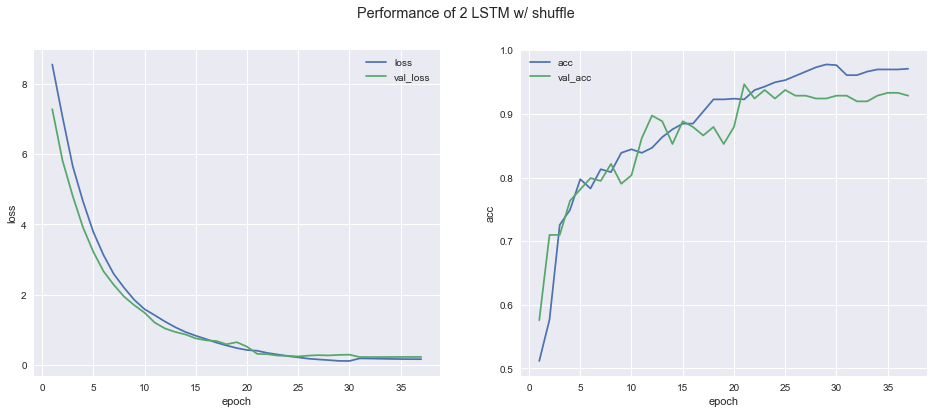

In [30]:
plot_history(history, 'Performance of 2 LSTM w/ shuffle', dictionary=True)

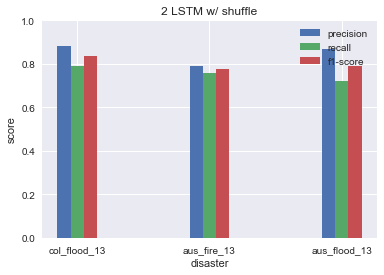

In [32]:
p, r, f = metric_drawing('2 LSTM w/ shuffle', path='2_lstm_shuffle.h5')

In [33]:
print p, r, f

[0.88083735909822869, 0.79202772963604851, 0.86956521739130432] [0.79160636758321279, 0.75913621262458475, 0.72180451127819545] [0.83384146341463417, 0.7752332485156912, 0.78882497945768282]


In [31]:
increment_learning_result(path='2_lstm_shuffle.h5')

no incremental learning:
917/917 [==============================] - 7s 8ms/step
[0.79695812670459143, 0.76226826647505763]
1079/1079 [==============================] - 4s 4ms/step
[0.82774364865411754, 0.75440222450270489]
1112/1112 [==============================] - 4s 3ms/step
[0.96554954189190767, 0.76888489251514136]
hard label:
917/917 [==============================] - 8s 9ms/step
[0.7840333086323712, 0.77317339188399981]
1079/1079 [==============================] - 7s 7ms/step
[0.82900678164103825, 0.75625579262133324]
1112/1112 [==============================] - 8s 7ms/step
[0.96590544336991346, 0.7715827333841393]
labels with weight:
917/917 [==============================] - 7s 8ms/step
[0.78396679699875926, 0.77426390442489412]
1079/1079 [==============================] - 9s 8ms/step
[0.83429281961818447, 0.75625579262133324]
1112/1112 [==============================] - 8s 7ms/step
[0.94573663196546565, 0.77607913626183711]


## 2 LSTM layer w/ 0.1 dropout w/ shuffle

In [34]:
%%time
model = Sequential()
model.add(Bidirectional(LSTM(64, kernel_initializer='he_normal', recurrent_dropout=0.1, dropout=0.1, return_sequences=True, 
                                 kernel_regularizer=regularizers.l2(0.01)),input_shape=(None,25)))
model.add(Bidirectional(LSTM(64, kernel_initializer='he_normal', recurrent_dropout=0.1, dropout=0.1, 
                                 kernel_regularizer=regularizers.l2(0.01))))
optimizer = Adam(lr=0.01)
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history=shuffle_train(model, col_fire_12, col_fire_12_g, '2_lstm_shuffle.h5', batch_size=640)

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 20s 22ms/step - loss: 8.4358 - acc: 0.4978 - val_loss: 7.3099 - val_acc: 0.4375
Epoch 2/10
893/893 [==============================] - 6s 7ms/step - loss: 6.9966 - acc: 0.5319 - val_loss: 5.7455 - val_acc: 0.6964
Epoch 3/10
893/893 [==============================] - 6s 7ms/step - loss: 5.5965 - acc: 0.6820 - val_loss: 4.7172 - val_acc: 0.6830
Epoch 4/10
893/893 [==============================] - 6s 7ms/step - loss: 4.5642 - acc: 0.7122 - val_loss: 3.8586 - val_acc: 0.7277
Epoch 5/10
893/893 [==============================] - 6s 6ms/step - loss: 3.7255 - acc: 0.7772 - val_loss: 3.2045 - val_acc: 0.7232
Epoch 6/10
893/893 [==============================] - 6s 7ms/step - loss: 3.0577 - acc: 0.7895 - val_loss: 2.7695 - val_acc: 0.7455
Epoch 7/10
893/893 [==========

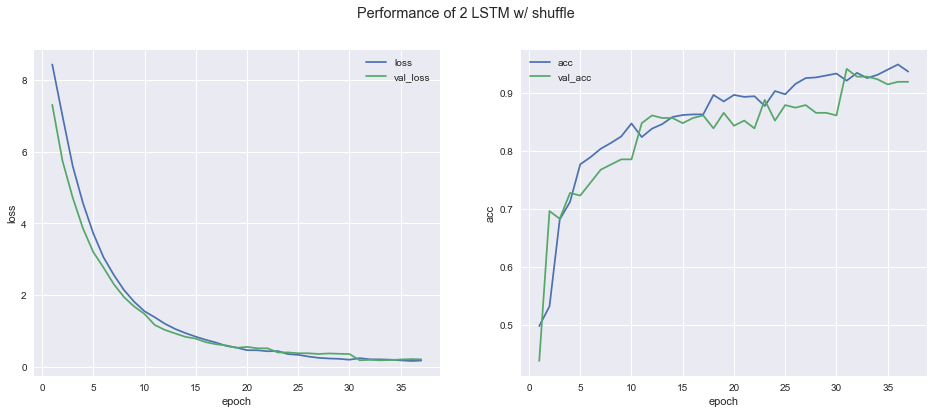

In [36]:
plot_history(history, 'Performance of 2 LSTM w/ shuffle', dictionary=True)

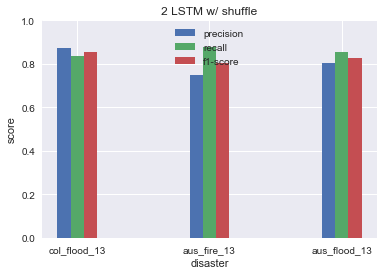

In [38]:
p, r, f = metric_drawing('2 LSTM w/ shuffle', path='2_lstm_shuffle.h5')

In [39]:
print p, r, f

[0.87291981845688349, 0.7464589235127479, 0.80225988700564976] [0.83502170767004347, 0.87541528239202659, 0.85413533834586464] [0.85355029585798814, 0.80581039755351669, 0.82738528769118713]


In [37]:
increment_learning_result(path='2_lstm_shuffle.h5')

no incremental learning:
917/917 [==============================] - 9s 10ms/step
[0.60137518652132838, 0.78407851716294286]
1079/1079 [==============================] - 4s 4ms/step
[0.66312359813410893, 0.76459684832655139]
1112/1112 [==============================] - 5s 4ms/step
[0.61171012462900698, 0.78687050316831186]
hard label:
917/917 [==============================] - 10s 11ms/step
[0.61330656409913609, 0.81679389332476982]
1079/1079 [==============================] - 9s 9ms/step
[0.71841947771643355, 0.77386468891969318]
1112/1112 [==============================] - 11s 10ms/step
[0.62798261942623335, 0.80125899280575541]
labels with weight:
917/917 [==============================] - 11s 12ms/step
[0.58959897484878154, 0.82224645602924096]
1079/1079 [==============================] - 10s 10ms/step
[0.78746281027020515, 0.75810935991135209]
1112/1112 [==============================] - 10s 9ms/step
[0.64477122923453078, 0.7958633089237076]


## 2 LSTM layer w/ 0.2 dropout w/ shuffle

In [40]:
%%time
model = Sequential()
model.add(Bidirectional(LSTM(64, kernel_initializer='he_normal', recurrent_dropout=0.2, dropout=0.2, return_sequences=True, 
                                 kernel_regularizer=regularizers.l2(0.01)),input_shape=(None,25)))
model.add(Bidirectional(LSTM(64, kernel_initializer='he_normal', recurrent_dropout=0.2, dropout=0.2, 
                                 kernel_regularizer=regularizers.l2(0.01))))
optimizer = Adam(lr=0.01)
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history=shuffle_train(model, col_fire_12, col_fire_12_g, '2_lstm_shuffle.h5', batch_size=640)

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 25s 28ms/step - loss: 8.6007 - acc: 0.4614 - val_loss: 7.1055 - val_acc: 0.6250
Epoch 2/10
893/893 [==============================] - 5s 6ms/step - loss: 6.9701 - acc: 0.5566 - val_loss: 5.8944 - val_acc: 0.5045
Epoch 3/10
893/893 [==============================] - 5s 6ms/step - loss: 5.7209 - acc: 0.6025 - val_loss: 4.7587 - val_acc: 0.7857
Epoch 4/10
893/893 [==============================] - 5s 6ms/step - loss: 4.6733 - acc: 0.7212 - val_loss: 3.8757 - val_acc: 0.7455
Epoch 5/10
893/893 [==============================] - 5s 6ms/step - loss: 3.8433 - acc: 0.6853 - val_loss: 3.1413 - val_acc: 0.8571
Epoch 6/10
893/893 [==============================] - 5s 6ms/step - loss: 3.1639 - acc: 0.7492 - val_loss: 2.5610 - val_acc: 0.8795
Epoch 7/10
893/893 [==========

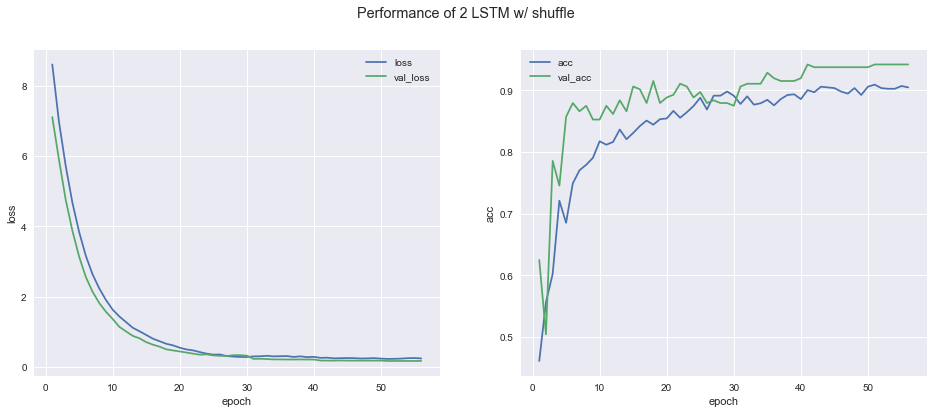

In [41]:
plot_history(history, 'Performance of 2 LSTM w/ shuffle', dictionary=True)

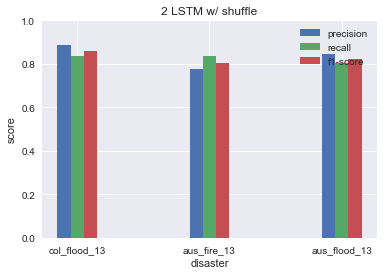

In [43]:
p, r, f = metric_drawing('2 LSTM w/ shuffle', path='2_lstm_shuffle.h5')

In [44]:
print p, r, f

[0.88632872503840243, 0.77743431221020087, 0.84384858044164035] [0.83502170767004347, 0.83554817275747506, 0.80451127819548873] [0.85991058122205655, 0.80544435548438753, 0.82371054657428788]


In [42]:
increment_learning_result(path='2_lstm_shuffle.h5')

no incremental learning:
917/917 [==============================] - 11s 12ms/step
[0.56539942465535686, 0.79498364270188426]
1079/1079 [==============================] - 4s 4ms/step
[0.57024522049765103, 0.7747914729790073]
1112/1112 [==============================] - 4s 4ms/step
[0.56360854524717052, 0.7940647482014388]
hard label:
917/917 [==============================] - 13s 14ms/step
[0.55554099593843731, 0.80370774296403846]
1079/1079 [==============================] - 13s 12ms/step
[0.58168740867463609, 0.77571825703832153]
1112/1112 [==============================] - 13s 12ms/step
[0.5584209177562659, 0.79856115107913672]
labels with weight:
917/917 [==============================] - 14s 15ms/step
[0.54704906499762829, 0.80479825556993223]
1079/1079 [==============================] - 16s 15ms/step
[0.57996337987185631, 0.77571825703832153]
1112/1112 [==============================] - 12s 11ms/step
[0.55875278446528553, 0.79586330935251803]


In [67]:
model = load_model('lstm_shuffle_3.h5')
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')